In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix)
import matplotlib.pyplot as plt

In [11]:
#Data Fetching  
def download_stock_data(symbol, period):
    """
    Downloads stock data from Yahoo Finance.
    Saves the data as CSV and returns a DataFrame.
    """
    try:
        print(f"Fetching {symbol} data for last {period} months...")
        stock = yf.Ticker(symbol)
        df = stock.history(period=period + "mo")
        
        filename = f'{symbol.lower()}_stock_data.csv'
        df.to_csv(filename)
        print(f"Data saved to {filename}")
        return df
    
    except Exception as error:
        raise RuntimeError(f"Error while downloading data: {error}")
        return pd.DataFrame()

In [12]:
#Feature Engineering
def calculate_rsi(prices, periods=14):
    """
    Calculates the Relative Strength Index (RSI) for a given price series.
    """
    delta = prices.diff()
    gains = np.where(delta > 0, delta, 0)
    losses = np.where(delta < 0, -delta, 0)
    
    avg_gain = pd.Series(gains).rolling(window=periods , min_periods= 1).mean()
    avg_loss = pd.Series(losses).rolling(window=periods , min_periods= 1).mean().replace(0, 0.0001)
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [5]:
def prepare_features(df):
    """
    Adds technical indicators and prepares features for modeling.
    Uses hybrid fill strategy for missing values (not zeros).
    """
    df['SMA5'] = df['Close'].rolling(window=5).mean()
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['RSI'] = calculate_rsi(df['Close'], periods=14)


    df['SMA5'].fillna(df['Close'], inplace=True)
    df['SMA20'].fillna(df['Close'], inplace=True)
    df['RSI'].fillna(50, inplace=True)  


    df['Overbought'] = (df['RSI'] >= 70).astype(int)
    df['Oversold'] = (df['RSI'] <= 30).astype(int)


    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    df.dropna(inplace=True)

    features = ['Close', 'Volume', 'SMA5', 'SMA20', 'RSI', 'Overbought', 'Oversold']
    
    return df[features], df['Target'], df

In [7]:
#Model Training
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , shuffle= False)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LogisticRegression(random_state=42 , max_iter= 500)
    model.fit(X_train_scaled, y_train)
    
    joblib.dump(model, "logistic_model.pkl")
    joblib.dump(scaler, "scaler.pkl")
    print("Model and scaler saved.")
    
    return model, scaler, X_test_scaled, y_test

In [8]:
#Model Evaluation
def evaluate_model(model, X_test_scaled, y_test):
    """
    Evaluates model performance using standard classification metrics.
    """
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    confusion = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Confusion Matrix:\n{confusion}")

In [ ]:
#Visualization
def plot_results(df, model, X_test_scaled, y_test):
    """
    Plots actual prices and probability of price increase predicted by model.
    """
    probabilities = model.predict_proba(X_test_scaled)[:, 1]
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], df['Close'][-len(y_test):], label='Actual Price', color='blue')
    plt.scatter(df.index[-len(y_test):], df['Close'][-len(y_test):],
                c=probabilities, cmap='viridis', label='Probability of Price Increase', s=60, alpha=0.8)

    plt.title('Stock Price Direction Prediction (Logistic Regression)')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.colorbar(label='Probability of Price Increase')
    plt.legend()
    plt.tight_layout()
    plt.savefig('logistic_price_prediction.png', dpi=300)
    print("Chart saved as logistic_price_prediction.png")

Fetching AAPL data for last 14 months...
Data saved to aapl_stock_data.csv
Model and scaler saved.
Accuracy: 0.47
Precision: 0.47
Recall: 0.59
F1-score: 0.52
AUC: 0.44
Confusion Matrix:
[[11 19]
 [12 17]]
📈 Chart saved as logistic_price_prediction.png


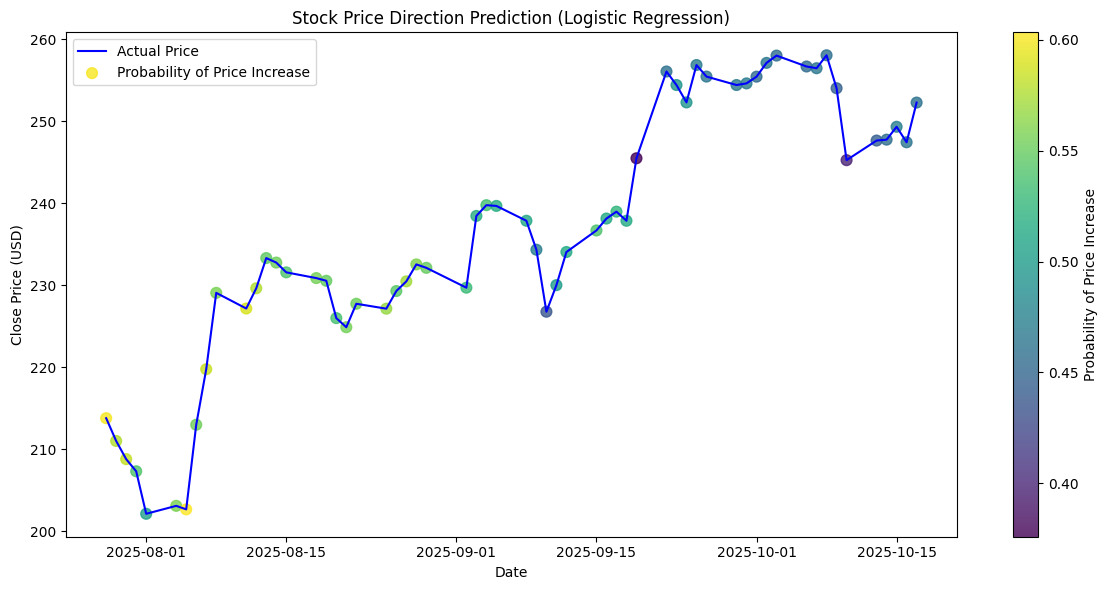

In [10]:
def main():
    symbol = input("Enter stock symbol (e.g. AAPL): ").upper()
    period = input("Enter period of time (months): ")

    df = download_stock_data(symbol, period)
    
    if df.empty:
        raise ValueError("No data received. Please check the stock symbol or period.")

    X, y, df = prepare_features(df)
    
    model, scaler, X_test_scaled, y_test = train_model(X, y)
    
    evaluate_model(model, X_test_scaled, y_test)
    
    plot_results(df, model, X_test_scaled, y_test)


if __name__ == "__main__":
    main()